In [250]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false; // disable scroll bar when displaying Folium map
}

<IPython.core.display.Javascript object>

# Assignment 2

Before working on this assignment please read these instructions fully. In the submission area, you will notice that you can click the link to **Preview the Grading** for each step of the assignment. This is the criteria that will be used for peer grading. Please familiarize yourself with the criteria before beginning the assignment.

The data for this assignment comes from a subset of The National Centers for Environmental Information (NCEI) [Global Historical Climatology Network daily (GHCNd)](https://www.ncei.noaa.gov/products/land-based-station/global-historical-climatology-network-daily) (GHCN-Daily). The GHCN-Daily is comprised of daily climate records from thousands of land surface stations across the globe - it's a wonderfully large dataset to play with! In particular, you will be asked to use data from the Ann Arbor Michigan location (my home!). and this is stored in the file: `assets/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv`

Each row in this datafile corresponds to a single observation from a weather station, and has the following variables:
* **id** : station identification code
* **date** : date in YYYY-MM-DD format (e.g. 2012-01-24 = January 24, 2012)
* **element** : indicator of element type
    * TMAX : Maximum temperature (tenths of degrees C)
    * TMIN : Minimum temperature (tenths of degrees C)
* **value** : data value for element (tenths of degrees C)

For this assignment, you must:

1. Read the documentation and familiarize yourself with the dataset, then write a python notebook which plots line graphs of the record high and record low temperatures by day of the year over the period 2005-2014. The area between the record high and record low temperatures for each day should be shaded.
2. Overlay a scatter of the 2015 data for any points (highs and lows) for which the ten year record (2005-2014) record high or record low was broken in 2015. (Based on the graph, do you think extreme weather is getting more frequent in 2015?)
3. Watch out for leap days (i.e. February 29th), it is reasonable to remove these points from the dataset for the purpose of this visualization.
4. Make the visual nice! Leverage principles from the first module in this course when developing your solution. Consider issues such as legends, labels, and chart junk.

I've written some steps I think would be good to go through, but there are other ways to solve this assignment so feel free to explore the pandas library! What I really want to see is an image that looks like this sketch I drew at my desk:

![](assets/chris_sketch.png)

In [251]:
#  I'll be using the folium package to render the data into a map in Jupyter.

import folium
import pandas as pd

# get the location information for this dataset
df = pd.read_csv('assets/BinSize_d400.csv')
station_locations_by_hash = df[df['hash'] == 'fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89']

# get longitude and lattitude to plot
lons = station_locations_by_hash['LONGITUDE'].tolist()
lats = station_locations_by_hash['LATITUDE'].tolist()

# plot on a beautiful folium map
my_map = folium.Map(location = [lats[0], lons[0]], height = 500,  zoom_start = 9)
for lat, lon in zip(lats, lons):
    folium.Marker([lat, lon]).add_to(my_map)

# render map in Jupyter
#display(my_map)

## Step 1
Load the dataset and transform the data into Celsius (refer to documentation) then extract all of the rows which have minimum or maximum temperatures.

__hint: when I did this step I had two DataFrame objects, each with ~80,000 entries in it__

In [252]:
import pandas as pd
df = pd.read_csv('assets/fb441e62df2d58994928907a91895ec62c2c42e6cd075c2700843b89.csv')
df = df.sort_values(by=['Date', 'ID']).reset_index(drop=True)
df['Data_Value'] = df['Data_Value']/10
df


,ID,Date,Element,Data_Value
0,USC00200032,2005-01-01,TMIN,-2.8
1,USC00200032,2005-01-01,TMAX,6.7
2,USC00200228,2005-01-01,TMAX,15.0
3,USC00200228,2005-01-01,TMIN,-3.9
4,USC00200230,2005-01-01,TMAX,12.2
...,...,...,...,...
165080,USW00014833,2015-12-31,TMAX,-1.0
165081,USW00014853,2015-12-31,TMAX,1.7
165082,USW00014853,2015-12-31,TMIN,0.0
165083,USW00094889,2015-12-31,TMAX,-0.5


In [253]:
# Crear dos DataFrames separados para TMIN y TMAX
df_tmin = df.loc[df['Element'] == 'TMIN']
df_tmax = df.loc[df['Element'] == 'TMAX']
df_tmin

,ID,Date,Element,Data_Value
0,USC00200032,2005-01-01,TMIN,-2.8
3,USC00200228,2005-01-01,TMIN,-3.9
5,USC00200230,2005-01-01,TMIN,-3.9
6,USC00200842,2005-01-01,TMIN,-2.2
8,USC00201502,2005-01-01,TMIN,-3.9
...,...,...,...,...
165076,USC00208972,2015-12-31,TMIN,-2.2
165078,USW00004848,2015-12-31,TMIN,-1.0
165079,USW00014833,2015-12-31,TMIN,-2.1
165082,USW00014853,2015-12-31,TMIN,0.0


## Step 2
In order to visualize the data we would plot the min and max data for each day of the year between the years 2005 and 2014 across all weather stations. But we also need to find out when the min or max temperature in 2015 falls below the min or rises above the max for the previous decade.

If you did step 1 you have two Series objects with min and max times for the years 2005 through 2015. You can use Pandas `groupby` to create max and min temperature Series objects across all weather stations for each day of these years, and you can deal with the records for February 29 (the leap year) by dropping them.

__hint: when I finished this step, I had two DataFrame objects, each with exactly 4015 observations in them__

In [254]:
# Agrupar por día y calcular los valores mínimos y máximos para cada día del año entre 2005 y 2014
df_tmin_grouped = df_tmin.groupby(['Date'])['Data_Value'].min()
df_tmax_grouped = df_tmax.groupby(['Date'])['Data_Value'].max()
# Convertir el índice de la serie a tipo datetime
df_tmin_grouped.index = pd.to_datetime(df_tmin_grouped.index)

# Filtrar para excluir el 29 de febrero
df_tmin_grouped = df_tmin_grouped[~((df_tmin_grouped.index.month == 2) & (df_tmin_grouped.index.day == 29))]

# Repetir para la serie df_tmax_grouped
df_tmax_grouped.index = pd.to_datetime(df_tmax_grouped.index)
df_tmax_grouped = df_tmax_grouped[~((df_tmax_grouped.index.month == 2) & (df_tmax_grouped.index.day == 29))]

df_tmin_grouped


Date
2005-01-01   -5.6
2005-01-02   -5.6
2005-01-03    0.0
2005-01-04   -3.9
2005-01-05   -9.4
             ... 
2015-12-27   -0.6
2015-12-28   -3.9
2015-12-29   -3.9
2015-12-30   -2.2
2015-12-31   -5.6
Name: Data_Value, Length: 4015, dtype: float64

## Step 3
Now that you have grouped the daily max and min temperatures for each day of the years 2005 through 2015, you can separate out the data for 2015. Then you can use the Pandas `groupby` function to find the max and min of the temperature data for each __day of the year__ for the 2005-2014 data.

__hint: at the end of this step I had two DataFrames, one of maximum and the other of minimum values, which each had 365 observations in them. I also had another pair of similar DataFrames but only for the year 2015.__

In [255]:
# calculate the minimum and maximum values for the years 2015
df_tmin_2015 = df_tmin_grouped.tail(365).reset_index(drop=True)
df_tmax_2015 = df_tmax_grouped.tail(365).reset_index(drop=True)
# Eliminar los datos de 2015 de df_tmin_grouped y df_tmax_grouped
df_tmin_grouped = df_tmin_grouped.head(-365)
df_tmax_grouped = df_tmax_grouped.head(-365)
# Calcular los valores mínimos y máximos para cada día del año entre 2005 y 2014
df_tmin_grouped_min = df_tmin_grouped.groupby(df_tmin_grouped.index.dayofyear).min().reset_index(drop=True)
df_tmax_grouped_max = df_tmax_grouped.groupby(df_tmax_grouped.index.dayofyear).max().reset_index(drop=True)
# Eliminar la última fila del DataFrame
df_tmin_grouped_min = df_tmin_grouped_min[:-1]
df_tmax_grouped_max = df_tmax_grouped_max[:-1]
df_tmin_2015
#df_tmin_grouped
#df_tmin_grouped_min


0     -13.3
1     -12.2
2      -6.7
3      -8.8
4     -15.5
       ... 
360    -0.6
361    -3.9
362    -3.9
363    -2.2
364    -5.6
Name: Data_Value, Length: 365, dtype: float64

## Step 4
Now it's time to plot! You need to explore matplotlib in order to plot line graphs of the min and max temperatures for the years 2005 through 2014 and to scatter plot __only__ the daily 2015 temperatures that exceeded those values.

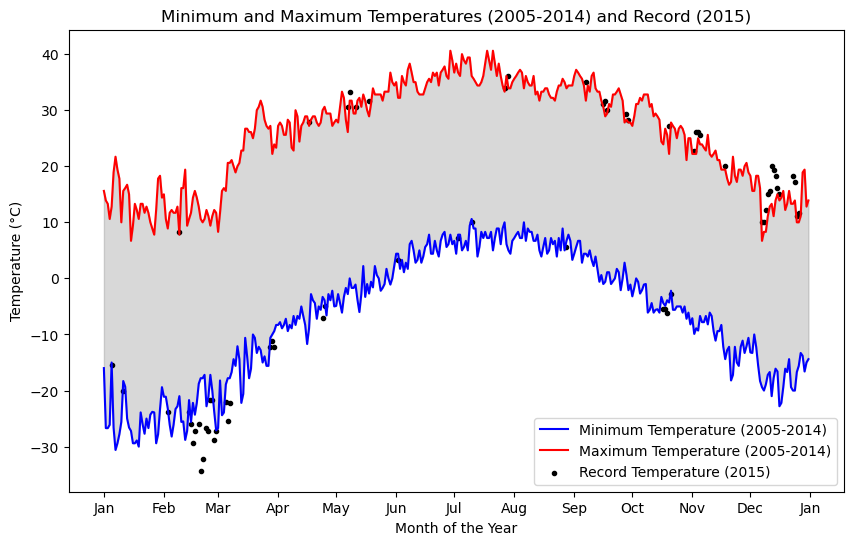

In [256]:
import matplotlib.pyplot as plt
from calendar import month_abbr
from matplotlib.dates import MonthLocator, DateFormatter

# Filter the daily temperatures of 2015 that exceed the minimum and maximum temperatures from 2005-2014
df_tmin_2015_exceed = df_tmin_2015[df_tmin_2015 < df_tmin_grouped_min.values]
df_tmax_2015_exceed = df_tmax_2015[df_tmax_2015 > df_tmax_grouped_max.values]

# Create the figure and axes
plt.figure(figsize=(10, 6))

# Plot the minimum and maximum temperatures from 2005-2014
plt.plot(df_tmin_grouped_min.index, df_tmin_grouped_min, color='blue', label='Minimum Temperature (2005-2014)')
plt.plot(df_tmax_grouped_max.index, df_tmax_grouped_max, color='red', label='Maximum Temperature (2005-2014)')

# Add shaded area between the curves of maximum and minimum temperatures from 2005-2014
plt.fill_between(df_tmin_grouped_min.index, df_tmin_grouped_min, df_tmax_grouped_max, color='gray', alpha=0.3)

# Add the record temperatures of 2015 as black points
plt.scatter(df_tmin_2015_exceed.index, df_tmin_2015_exceed, color='black', marker='.', label='Record Temperature (2015)')
plt.scatter(df_tmax_2015_exceed.index, df_tmax_2015_exceed, color='black', marker='.')

# Add title and labels
plt.title('Minimum and Maximum Temperatures (2005-2014) and Record (2015)')
plt.xlabel('Month of the Year')
plt.ylabel('Temperature (°C)')

# Set the ticks and labels of the x-axis
plt.gca().xaxis.set_major_locator(MonthLocator())
plt.gca().xaxis.set_major_formatter(DateFormatter('%b'))

# Add legend
plt.legend()

# Show the plot
plt.show()

